In [1]:
%matplotlib inline
from __future__ import division, print_function
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

cell_type = "HepG2"
%cd $cell_type

/users/avanti/interpret-benchmark/data/HepG2


In [2]:
!zcat positives_not_in_small_valid_labels.gz | wc -l

12394


### Load positives not seen in training or validation set

In [3]:
import momma_dragonn
from momma_dragonn.data_loaders.pyfasta_data_loader import SingleStreamSeqOnly
import numpy as np
import gzip

fasta_data_source = "/mnt/data/annotations/by_organism/human/hg19.GRCh37/hg19.genome.fa"
positives_data_loader = SingleStreamSeqOnly(batch_size=50, bed_source="positives_not_in_small_valid_labels.gz",
                                  fasta_data_source=fasta_data_source,
                                  rc_augment=False, randomize_after_pass=False, num_to_load_for_eval=None)
positives_data = positives_data_loader.get_data()

Reading bed file positives_not_in_small_valid_labels.gz into memory
Finished reading bed file into memory; got 12394rows


### Load some model

In [4]:
!ls model_files

model_2ObnU_modelJson.json	      record_2_model_IH83H_modelWeights.h5
model_2ObnU_modelWeights.h5	      record_3_model_0FT6i_modelJson.json
model_qyto7_modelJson.json	      record_3_model_0FT6i_modelWeights.h5
model_qyto7_modelWeights.h5	      record_4_model_Dvrnb_modelJson.json
model_UqOJX_modelJson.json	      record_4_model_Dvrnb_modelWeights.h5
model_UqOJX_modelWeights.h5	      record_5_model_1Q9Lp_modelJson.json
record_1_model_v4VYz_modelJson.json   record_5_model_1Q9Lp_modelWeights.h5
record_1_model_v4VYz_modelWeights.h5  record_6_model_svFYA_modelJson.json
record_2_model_IH83H_modelJson.json   record_6_model_svFYA_modelWeights.h5


In [5]:
import deeplift
from deeplift.conversion import kerasapi_conversion as kc

In [6]:
model_json = "model_files/record_1_model_v4VYz_modelJson.json"
model_weights = "model_files/record_1_model_v4VYz_modelWeights.h5"
#model_json = "model_files/model_UqOJX_modelJson.json"
#model_weights = "model_files/model_UqOJX_modelWeights.h5"
deeplift_genomicsdefault_model =\
    kc.convert_model_from_saved_files(
        json_file=model_json,
        h5_file=model_weights,
        nonlinear_mxts_mode=deeplift.layers.NonlinearMxtsMode.DeepLIFT_GenomicsDefault) 
deeplift_rescale_model =\
    kc.convert_model_from_saved_files(
        json_file=model_json,
        h5_file=model_weights,
        nonlinear_mxts_mode=deeplift.layers.NonlinearMxtsMode.Rescale) 

nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 2 the preceding linear layer is 0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 6 the preceding linear layer is 4 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 10 the preceding linear layer is 8 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 15 the preceding linear layer is 13 of type Dense;
In accordance with nonlinea

### Sanity check that the model performs reasonably

In [8]:
#valid_data_loader = SingleStreamSeqOnly(batch_size=50, bed_source="small_valid_labels.gz",
#                                  fasta_data_source=fasta_data_source,
#                                  rc_augment=False, randomize_after_pass=False, num_to_load_for_eval=None)
#valid_data = valid_data_loader.get_data()

Reading bed file small_valid_labels.gz into memory
Finished reading bed file into memory; got 72233rows


Do a basic investigation of GC fraction

Negatives ACGT frac
[0.28822331 0.21220178 0.21261666 0.28692913]
Positives ACGT frac
[0.25293443 0.24930445 0.24927166 0.24848946]
for negatives


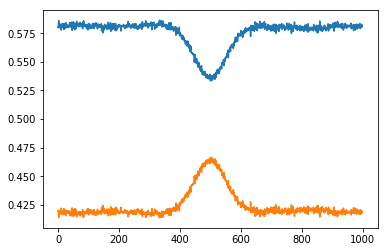

for positives


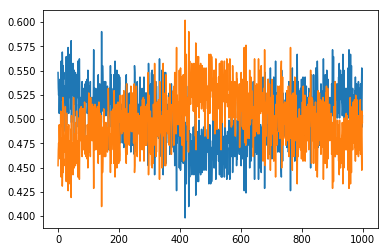

In [28]:
#mean_neg = np.mean(valid_data.X[valid_data.Y.squeeze()==0],axis=0)
#mean_pos = np.mean(valid_data.X[valid_data.Y.squeeze()==1],axis=0)
#print("Negatives ACGT frac")
#print(np.mean(valid_data.X[valid_data.Y.squeeze()==0],axis=(0,1)))
#print("Positives ACGT frac")
#print(np.mean(valid_data.X[valid_data.Y.squeeze()==1],axis=(0,1)))
#print("for negatives")
#plt.plot(range(1000),mean_neg[:,0]+mean_neg[:,3])
#plt.plot(range(1000),mean_neg[:,1]+mean_neg[:,2])
#plt.show()
#print("for positives")
#plt.plot(range(1000),mean_pos[:,0]+mean_pos[:,3])
#plt.plot(range(1000),mean_pos[:,1]+mean_pos[:,2])
#plt.show()

In [8]:
pred_func = deeplift.util.compile_func(inputs=[deeplift_genomicsdefault_model.get_layers()[0].get_activation_vars()],
                                       outputs=deeplift_genomicsdefault_model.get_layers()[-2].get_activation_vars())

In [9]:
#valid_preds = np.array(deeplift.util.run_function_in_batches(pred_func,
#                            input_data_list=[valid_data.X],
#                            batch_size=200,
#                            progress_update=10000))

Done 0
Done 10000
Done 20000
Done 30000
Done 40000
Done 50000
Done 60000
Done 70000


Using TensorFlow backend.


In [9]:
unseen_positives_preds = np.array(deeplift.util.run_function_in_batches(pred_func,
                            input_data_list=[positives_data.X],
                            batch_size=200,
                            progress_update=10000))

Done 0
Done 10000


Using TensorFlow backend.


0.9070251479705824


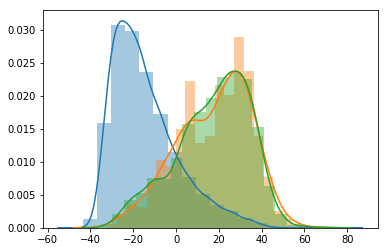

In [63]:
#import seaborn as sns
#from sklearn.metrics import roc_auc_score
#print(roc_auc_score(y_true=valid_data.Y.squeeze(), y_score=np.array(valid_preds).squeeze()))
#from matplotlib import pyplot as plt
##histogram the predictions
#sns.distplot(valid_preds[valid_data.Y.squeeze()==0],bins=20)
#sns.distplot(valid_preds[valid_data.Y.squeeze()==1],bins=20)
#sns.distplot(unseen_positives_preds,bins=20)
#plt.show()

### Prepare the deeplift, gradients and integrated gradients scoring functions

Utility functions for dinuc shuffling

In [10]:
from deeplift import dinuc_shuffle

argmax_to_letter = {0:'A', 1:'C', 2:'G', 3:'T'}
def onehot_to_seq(onehot):
    seq = "".join([argmax_to_letter[x] for x in np.argmax(onehot,axis=-1)])
    return seq

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
positives_seqs = [onehot_to_seq(x) for x in positives_data.X]

Look at prediction with flat references

In [11]:
print("Prediction under all zero input",pred_func([np.zeros((1,1000,4))]))
avgpos_gcref = np.mean(positives_data.X, axis=0, keepdims=True)
print("Prediction under avg pos input", pred_func([avgpos_gcref]))

Prediction under all zero input [[-14.88747]]
Prediction under avg pos input [[116.84889]]


Compile the various scoring functions

In [24]:
import tensorflow as tf
grad = tf.gradients(ys=deeplift_genomicsdefault_model.get_layers()[-2].get_activation_vars(),
                    xs=deeplift_genomicsdefault_model.get_layers()[0].get_activation_vars())[0]
unbatched_grad_func = deeplift.util.compile_func(
                        inputs=[deeplift_genomicsdefault_model.get_layers()[0].get_activation_vars()],
                        outputs=grad)

def list_wrapper(func):
    def wrapped_func(input_data_list, **kwargs):
        if (isinstance(input_data_list, list)):
            remove_list_on_return=False
        else:
            remove_list_on_return=True
            input_data_list = [input_data_list]
        to_return = func(input_data_list=input_data_list,
                         **kwargs)
        return to_return
    return wrapped_func

@list_wrapper
def grad_func(input_data_list, input_references_list, task_idx, **kwargs):
    assert len(input_data_list)==1
    to_return = np.array(deeplift.util.run_function_in_batches(
                    unbatched_grad_func,
                    input_data_list=input_data_list,
                    **kwargs))
    return to_return

@list_wrapper
def grad_times_inp_func(input_data_list, **kwargs):
    assert len(input_data_list)==1
    print("Ignoring reference for grad*input")
    grads = grad_func(input_data_list=input_data_list, **kwargs)
    return grads*input_data_list[0]

def get_project_onto_bases_func(func):
    @list_wrapper
    def project_onto_bases(input_data_list, **kwargs):
        assert len(input_data_list)==1
        to_return = func(input_data_list=input_data_list, **kwargs)
        return input_data_list[0]*np.sum(to_return,axis=-1)[:,:,None]
    return project_onto_bases

intgrad_func = get_project_onto_bases_func(deeplift.util.get_integrated_gradients_function(
                    gradient_computation_function=grad_func, 
                    num_intervals=10))

deeplift_genomicsdefault_contribs_func = get_project_onto_bases_func(
    deeplift_genomicsdefault_model.get_target_contribs_func(find_scores_layer_idx=0))
deeplift_rescale_contribs_func = get_project_onto_bases_func(
    deeplift_rescale_model.get_target_contribs_func(find_scores_layer_idx=0))

deeplift_genomicsdefault_dinucshuff_scoringfunc = deeplift.util.get_shuffle_seq_ref_function(
    score_computation_function=deeplift_genomicsdefault_contribs_func,
    shuffle_func=deeplift.dinuc_shuffle.dinuc_shuffle,
    one_hot_func=lambda x: np.array([one_hot_encode_along_channel_axis(y) for y in x]))

deeplift_rescale_dinucshuff_scoringfunc = deeplift.util.get_shuffle_seq_ref_function(
    score_computation_function=deeplift_rescale_contribs_func,
    shuffle_func=deeplift.dinuc_shuffle.dinuc_shuffle,
    one_hot_func=lambda x: np.array([one_hot_encode_along_channel_axis(y) for y in x]))

intgrad_dinucshuff_scoringfunc = deeplift.util.get_shuffle_seq_ref_function(
    score_computation_function=intgrad_func,
    shuffle_func=deeplift.dinuc_shuffle.dinuc_shuffle,
    one_hot_func=lambda x: np.array([one_hot_encode_along_channel_axis(y) for y in x]))
    
method_name_to_scoring_func = {
                 'grad_times_inp': grad_times_inp_func,
                 'integrated_grad': intgrad_func,
                 'deeplift_genomicsdefault': deeplift_genomicsdefault_contribs_func,
                 'deeplift_rescale': deeplift_rescale_contribs_func,
                 'deeplift_genomicsdefault_dinucshuff': deeplift_genomicsdefault_dinucshuff_scoringfunc,
                 'deeplift_rescale_dinucshuff': deeplift_rescale_dinucshuff_scoringfunc,
                 'integrated_grad_dinucshuff': intgrad_dinucshuff_scoringfunc}

### Compute scores with different references

In [13]:
sorted_prediction_indices = [x[0] for x in sorted(enumerate(unseen_positives_preds),
                             key=lambda x: -x[1])]
subset_indices = sorted_prediction_indices[::100]
positives_X_subset_preds = np.array([unseen_positives_preds[i] for i in subset_indices])
positives_X_subset = np.array([positives_data.X[i] for i in subset_indices])
positives_X_subset_seqs = [positives_seqs[i] for i in subset_indices]

Compute scores on unseen positives

In [ ]:
method_to_scores_flatref = {}
method_to_scores_avgposref = {}
method_to_scores_shuffref = {}

for method_name in ['integrated_grad_dinucshuff',
                    'deeplift_rescale_dinucshuff',
                    'deeplift_genomicsdefault_dinucshuff']:
    print(method_name)
    scores_shuffref = method_name_to_scoring_func[method_name](
        task_idx=0, input_data_sequences=positives_X_subset_seqs, num_refs_per_seq=10,
        batch_size=200, seed=1, progress_update=1000)
    method_to_scores_shuffref[method_name] = scores_shuffref

for method_name in ['grad_times_inp',
                    'integrated_grad',
                    'deeplift_rescale',
                    'deeplift_genomicsdefault']:
    print(method_name)
    scoring_func = method_name_to_scoring_func[method_name]
    scores_flatref = np.array(scoring_func(input_data_list=[positives_X_subset],
                          input_references_list=[np.zeros_like(positives_X_subset)],
                          task_idx=0, batch_size=10, progress_update=1000))
    print("avgposref")
    scores_avgposref = np.array(scoring_func(input_data_list=[positives_X_subset],
                          input_references_list=[np.array([avgpos_gcref[0] for x in positives_X_subset])],
                          task_idx=0, batch_size=10, progress_update=1000))
    method_to_scores_flatref[method_name] = scores_flatref
    method_to_scores_avgposref[method_name] = scores_avgposref


integrated_grad_dinucshuff
1000 reference seqs generated
One hot encoding sequences...
One hot encoding done...
Done 0
Done 1000
Done 2000
Done 3000
Done 4000
Done 5000
Done 6000
Done 7000
Done 8000
Done 9000
Done 10000
Done 11000
Done 12000
deeplift_rescale_dinucshuff
1000 reference seqs generated
One hot encoding sequences...
One hot encoding done...
Done 0
Done 1000
deeplift_genomicsdefault_dinucshuff
1000 reference seqs generated
One hot encoding sequences...
One hot encoding done...
Done 0
Done 1000
grad_times_inp
Ignoring reference for grad*input
Done 0
avgposref
Ignoring reference for grad*input
Done 0
integrated_grad
Done 0
Done 1000
avgposref
Done 0
Done 1000
deeplift_rescale
Done 0
avgposref
Done 0
deeplift_genomicsdefault
Done 0
avgposref
Done 0


1
11214
[49.653194]
integrated_grad_dinucshuff


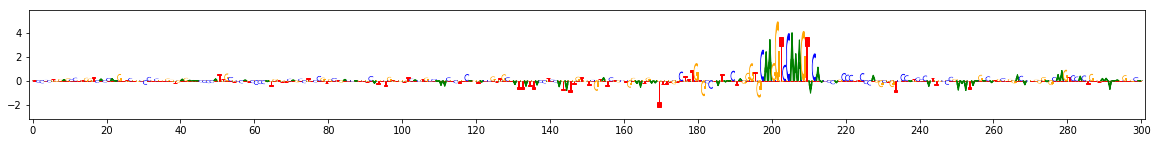

deeplift_rescale_dinucshuff


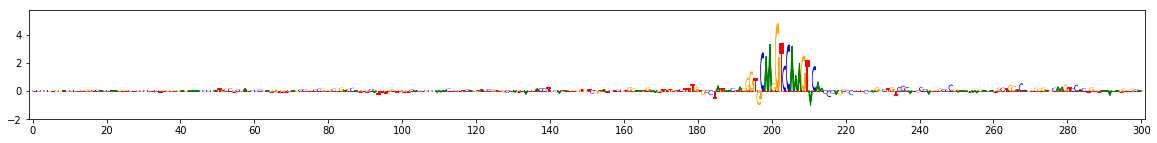

deeplift_genomicsdefault_dinucshuff


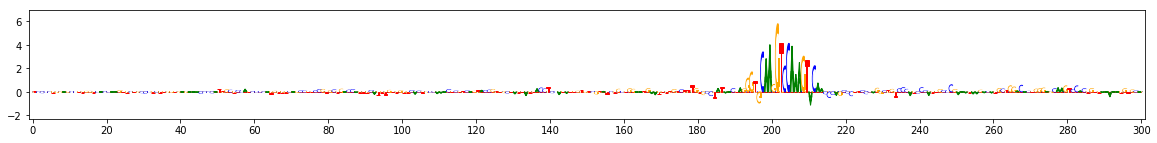

grad_times_inp
flat ref


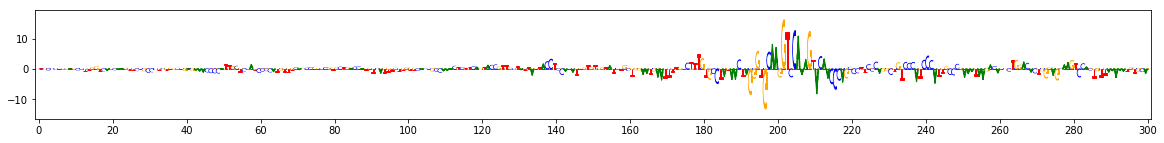

integrated_grad
flat ref


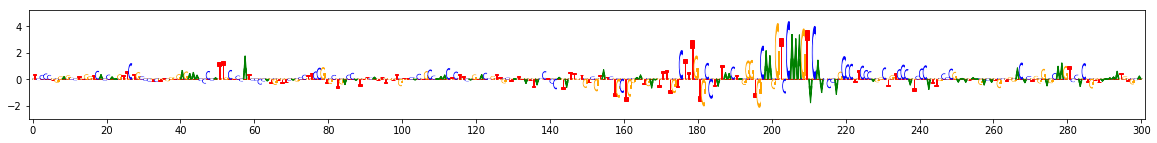

gc ref


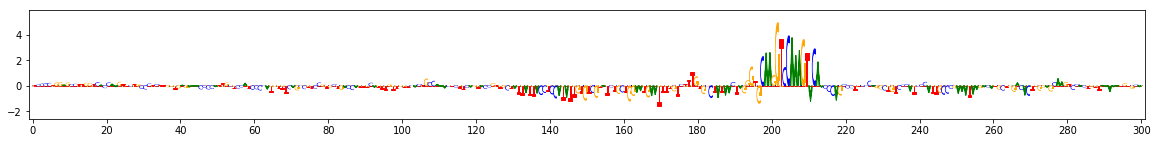

deeplift_rescale
flat ref


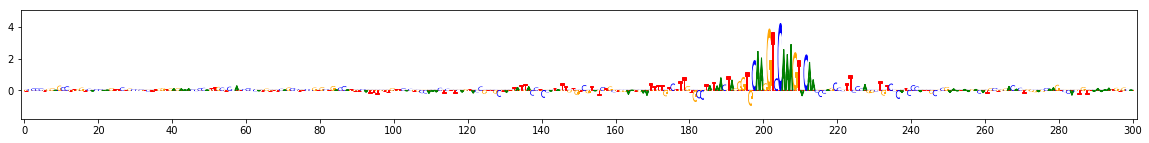

gc ref


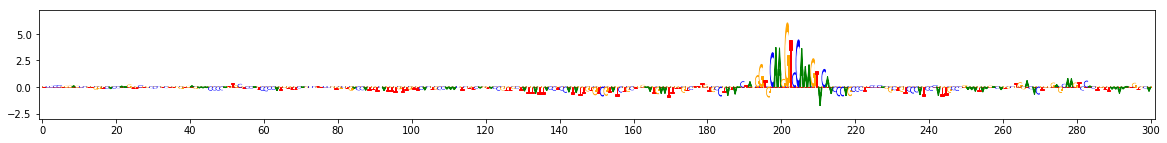

deeplift_genomicsdefault
flat ref


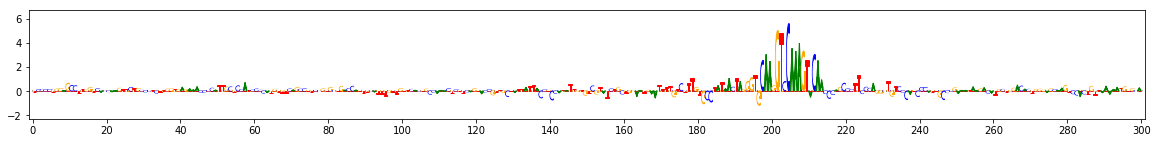

gc ref


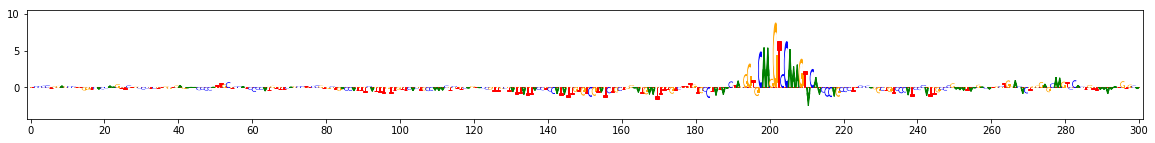

11
5760
[38.129673]
integrated_grad_dinucshuff


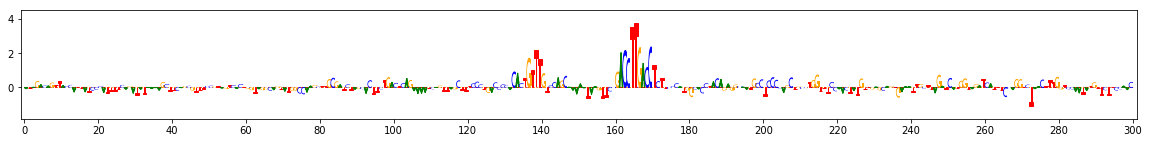

deeplift_rescale_dinucshuff


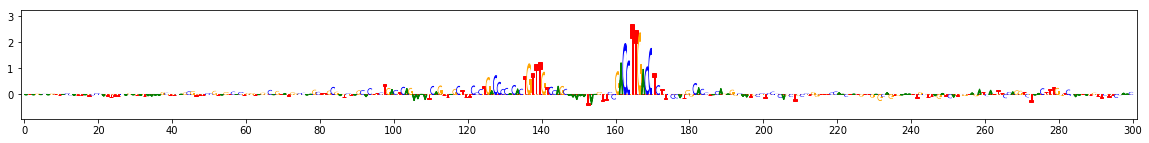

deeplift_genomicsdefault_dinucshuff


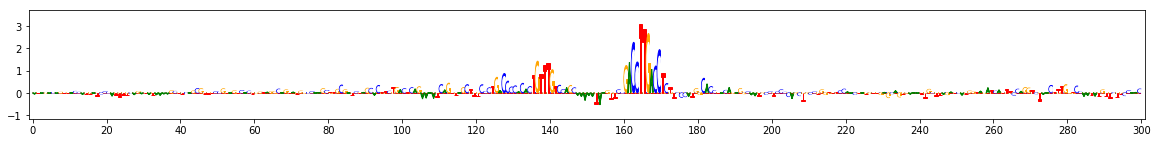

grad_times_inp
flat ref


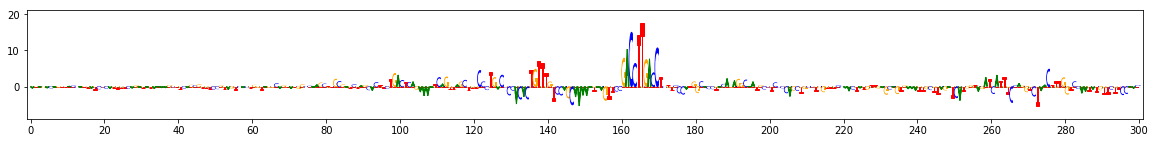

integrated_grad
flat ref


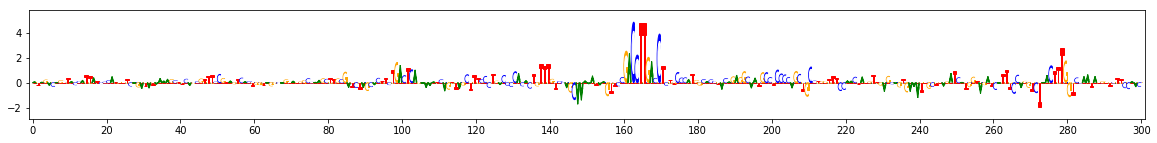

gc ref


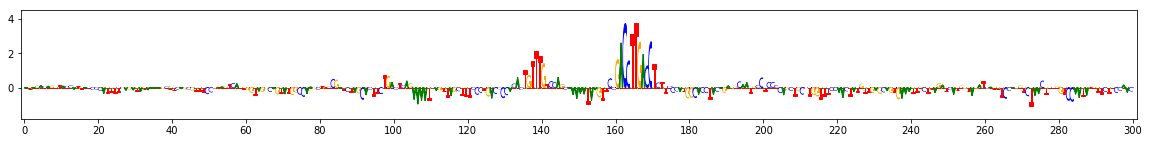

deeplift_rescale
flat ref


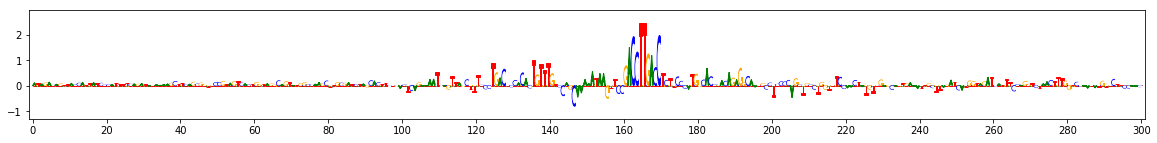

gc ref


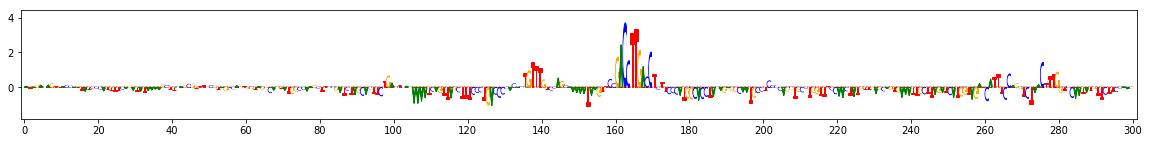

deeplift_genomicsdefault
flat ref


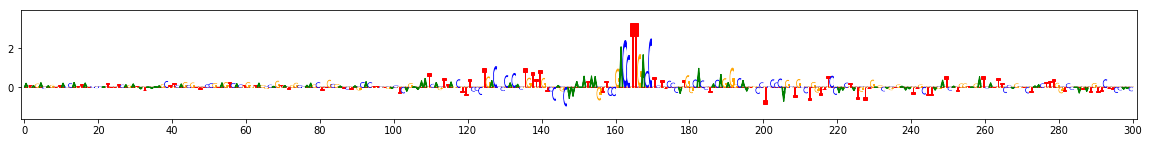

gc ref


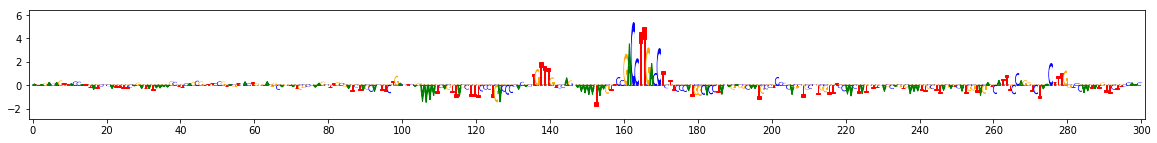

21
6327
[33.812706]
integrated_grad_dinucshuff


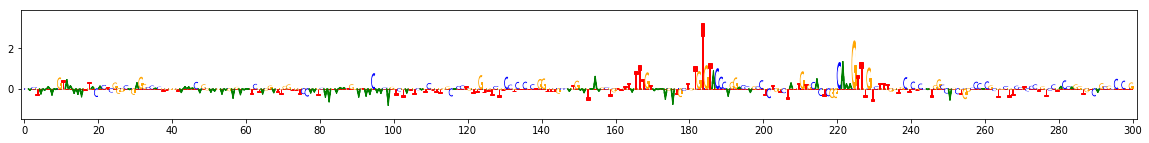

deeplift_rescale_dinucshuff


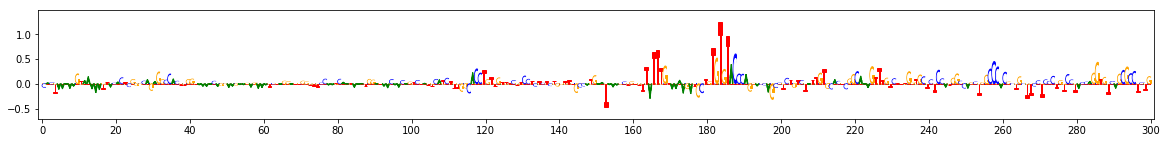

deeplift_genomicsdefault_dinucshuff


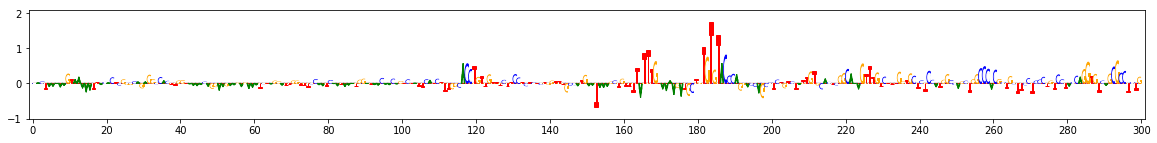

grad_times_inp
flat ref


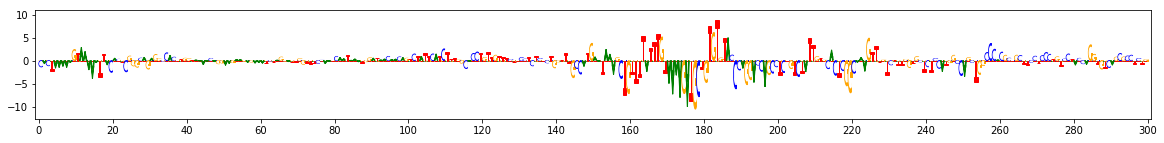

integrated_grad
flat ref


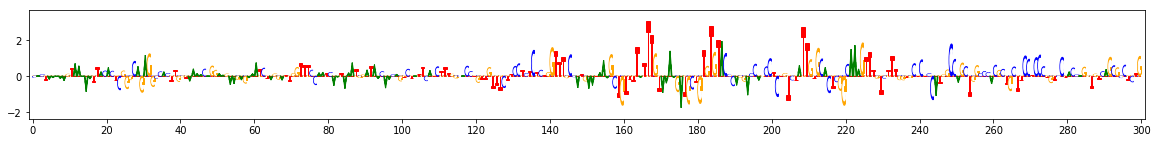

gc ref


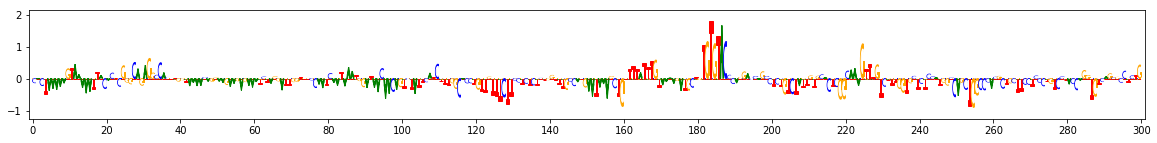

deeplift_rescale
flat ref


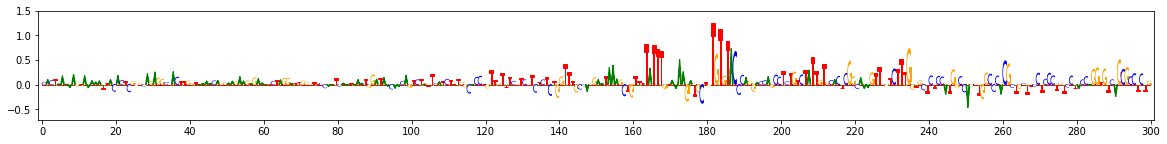

gc ref


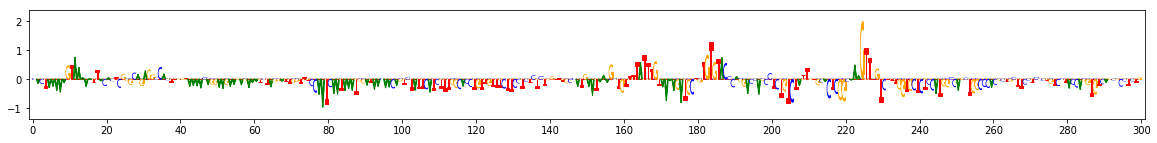

deeplift_genomicsdefault
flat ref


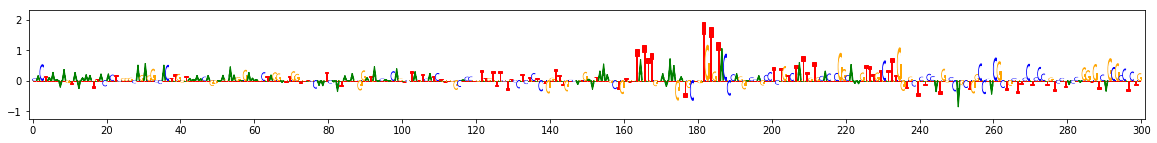

gc ref


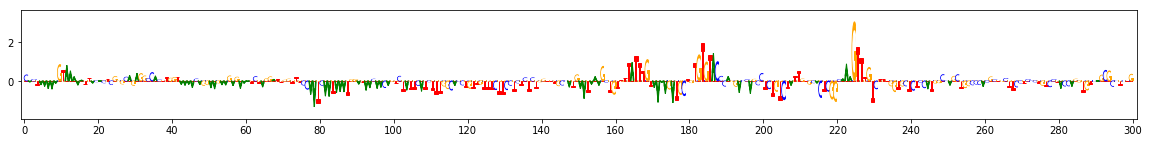

31
2948
[30.391394]
integrated_grad_dinucshuff


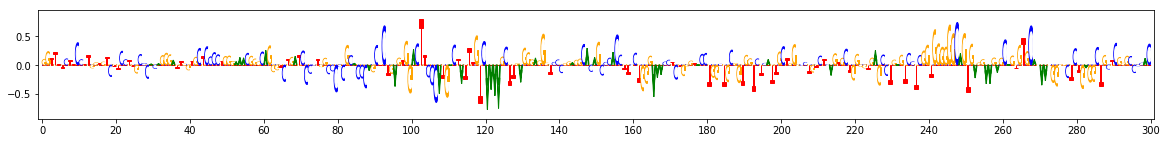

deeplift_rescale_dinucshuff


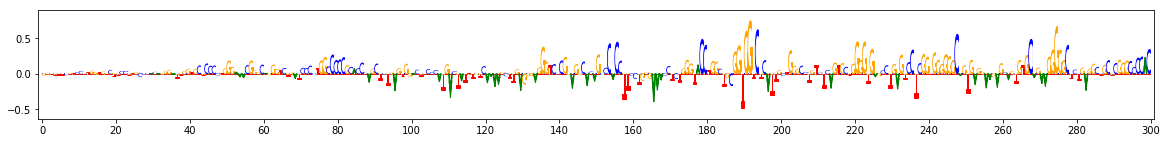

deeplift_genomicsdefault_dinucshuff


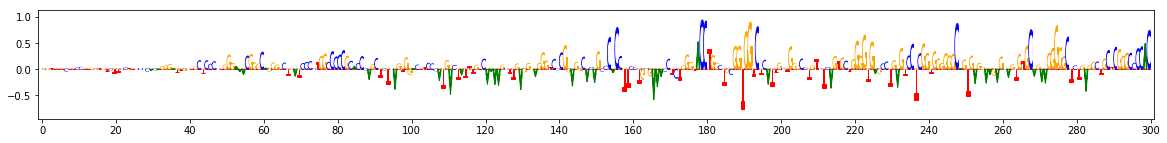

grad_times_inp
flat ref


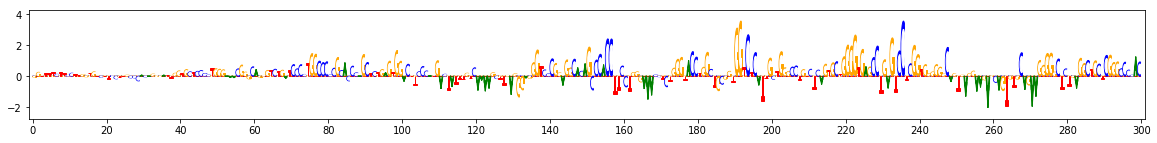

integrated_grad
flat ref


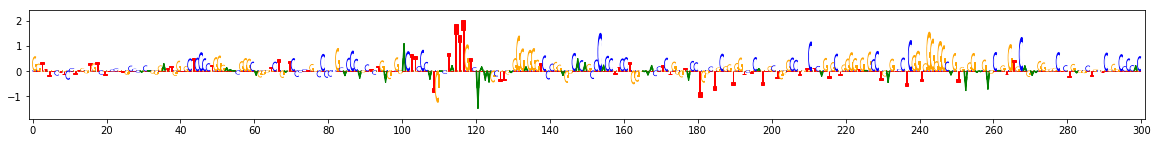

gc ref


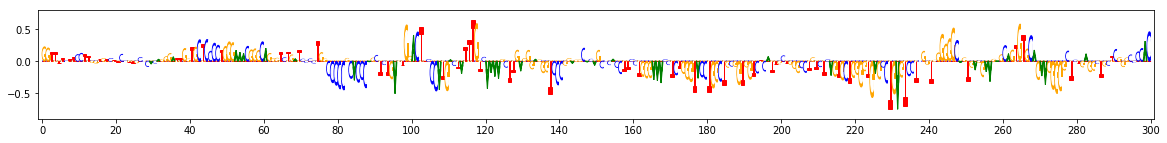

deeplift_rescale
flat ref


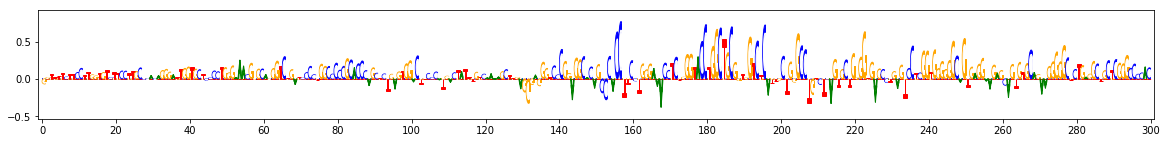

gc ref


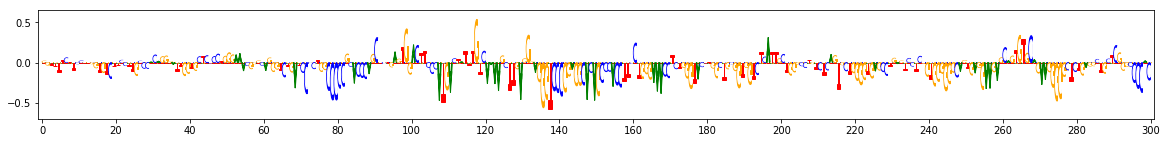

deeplift_genomicsdefault
flat ref


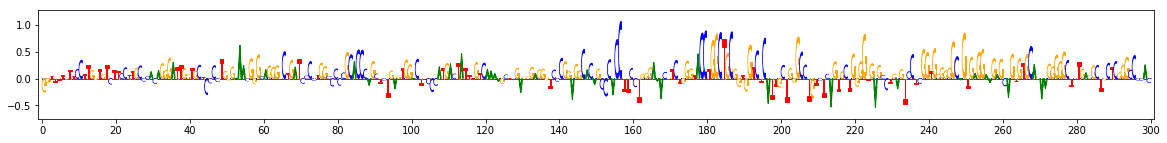

gc ref


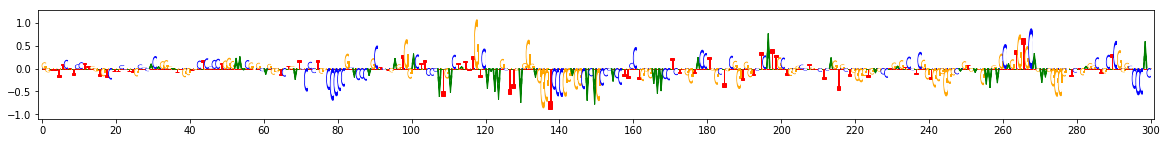

41
11606
[26.987026]
integrated_grad_dinucshuff


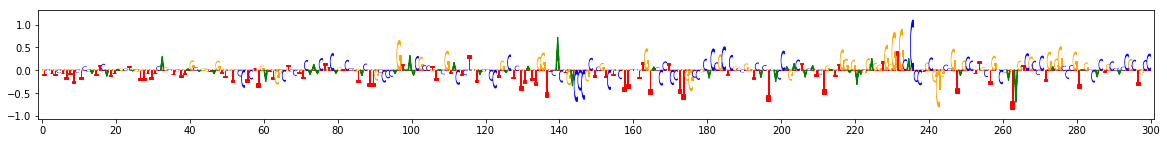

deeplift_rescale_dinucshuff


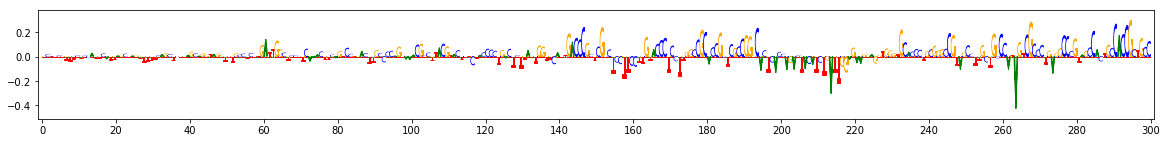

deeplift_genomicsdefault_dinucshuff


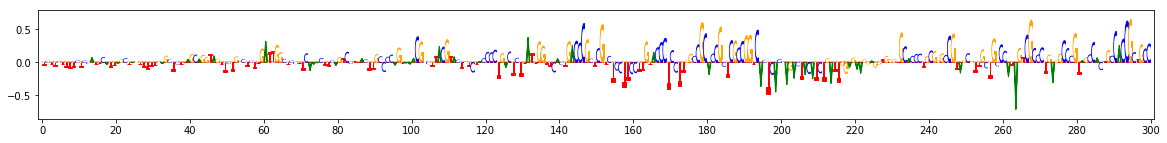

grad_times_inp
flat ref


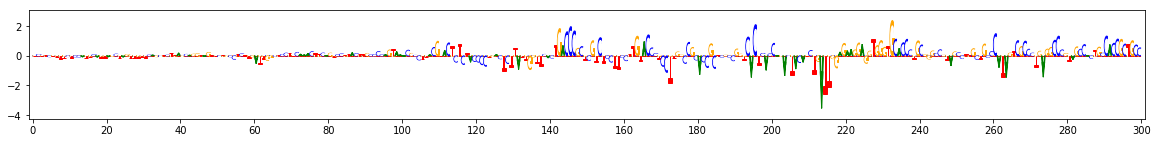

integrated_grad
flat ref


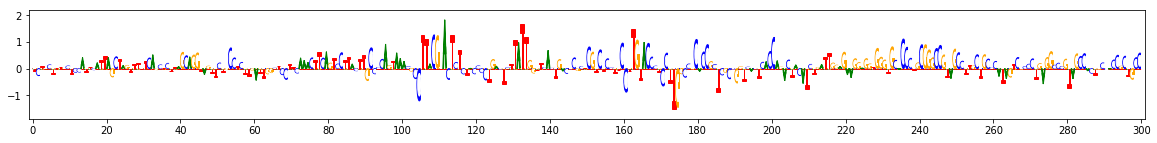

In [ ]:
from deeplift.visualization import viz_sequence

for i in range(1,len(positives_X_subset_preds),10):
    print(i)
    print(subset_indices[i])
    print(positives_X_subset_preds[i])
    
    for method_name in ['integrated_grad_dinucshuff',
                        'deeplift_rescale_dinucshuff',
                        'deeplift_genomicsdefault_dinucshuff']:
        print(method_name)
        viz_sequence.plot_weights(
            method_to_scores_shuffref[method_name][i,300:600],
            subticks_frequency=20)
    
    for method_name in ['grad_times_inp', 'integrated_grad', 'deeplift_rescale', 'deeplift_genomicsdefault']:
        print(method_name)
        print("flat ref")
        viz_sequence.plot_weights(
            method_to_scores_flatref[method_name][i,300:600],
            subticks_frequency=20)
        if (method_name != 'grad_times_inp'):
            print("gc ref")
            viz_sequence.plot_weights(
                method_to_scores_avgposref[method_name][i,300:600],
                subticks_frequency=20)

Explore preds on dinuc shuffled seqs

In [14]:
dinuc_shuff_positives_seqs = [deeplift.dinuc_shuffle.dinuc_shuffle(x) for x in positives_seqs]
dinuc_shuff_positives_onehot = np.array([one_hot_encode_along_channel_axis(x) for x in dinuc_shuff_positives_seqs])

Get preds on dinuc shuffled sequences

In [15]:
dinuc_shuff_positives_preds = np.array(deeplift.util.run_function_in_batches(pred_func,
                            input_data_list=[dinuc_shuff_positives_onehot],
                            batch_size=200,
                            progress_update=10000))

Done 0
Done 10000
Done 0
Done 10000


Get preds on randomly shuffled sequences

In [23]:
from random import shuffle

def random_shuff_seq(seq):
    arr = [x for x in seq]
    shuffle(arr)
    return "".join(arr)

random_shuff_positives_seqs = [random_shuff_seq(x) for x in positives_seqs]
random_shuff_positives_onehot = np.array([one_hot_encode_along_channel_axis(x) for x in random_shuff_positives_seqs])
random_shuff_positives_preds = np.array(deeplift.util.run_function_in_batches(pred_func,
                            input_data_list=[random_shuff_positives_onehot],
                            batch_size=200,
                            progress_update=10000))

Done 0
Done 10000


0.9070251479705824


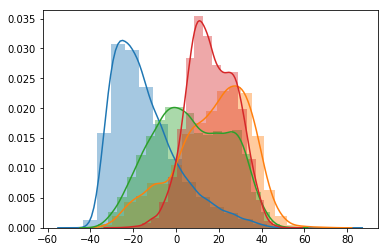

In [24]:
import seaborn as sns
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_true=valid_data.Y.squeeze(), y_score=np.array(valid_preds).squeeze()))
from matplotlib import pyplot as plt
#histogram the predictions
sns.distplot(valid_preds[valid_data.Y.squeeze()==0],bins=20)
#sns.distplot(valid_preds[valid_data.Y.squeeze()==1],bins=20)
sns.distplot(unseen_positives_preds,bins=20)
sns.distplot(dinuc_shuff_positives_preds,bins=20)
sns.distplot(random_shuff_positives_preds,bins=20)
plt.show()

In [ ]:
#save space by deleting the validation data
#del valid_data
#del valid_preds